![](pytorch-logo-dark.svg)

# PyTorch for Neural Networks
## Thomas Viehmann, MathInf GmbH
## April 2022

In [1]:
import torch

In [2]:
import graphviz

import ipywidgets
import IPython.display
import IPython
import tempfile
import os

# global callback and register
registered_jit_visualizations = {}
def on_click_in_jit_visualization(objid, t):
    # careful, if this throws an error, you won't notice
    registered_jit_visualizations[objid](t)
    return

class JITVisualizer:
    def __init__(self, mod, *, classes_to_visit=None, submodules_to_visit=None, expanded_names=None):
        self.mod = mod
        self.classes_to_visit = classes_to_visit or []  # default to no subclasses
        self.classes_found = set()
        self.submodules_to_visit = submodules_to_visit or set()
        self.expanded_names = expanded_names or set()
        self.js_display_id = None
        self.clickseq = []

    def make_node(self, dot, name, *, clickable=False, **kwargs):
        assert name not in self.node_ids
        nid = str(len(self.node_names))
        self.node_names.append(name)
        self.node_ids[name] = nid
        if 'label' not in kwargs:
            dot.node(self.node_ids[name], label=name, **kwargs)
        else:
            dot.node(self.node_ids[name], **kwargs)

    def make_edge(self, dot, n1, n2):
        dot.edge(self.node_ids[n1], self.node_ids[n2])

    def make_graph(self):
        self.node_ids = {}
        self.node_names = [None]
        self.cluster_ids = {}
        self.cluster_names = [None]
        return self._make_graph(mod=self.mod)

    def cluster_id(self, name):
        cid = 'cluster_' + str(len(self.cluster_names))
        self.cluster_names.append(name)
        self.cluster_ids[name] = cid
        return cid

    def is_relevant_type(self, t):
        kind = t.kind()
        if kind == 'TensorType':
            return True
        if kind in ('ListType', 'OptionalType'):
            return self.is_relevant_type(t.getElementType())
        if kind == 'TupleType':
            return any([self.is_relevant_type(tt) for tt in t.elements()])
        return False

    def make_svg(self):
        self.DEBUG_could_expand = []
        graph = self.make_graph()
        with tempfile.TemporaryDirectory() as d:
            res = graph.render(os.path.join(d, 'gr'))
            svg = open(res).read()
        return svg

    def _make_graph(self, *, mod, dot=None, prefix="", input_preds=None, parent_dot=None):
        gr = mod.graph
        preds = {}

        def find_name(i, self_input, suffix=None):
            if i == self_input:
                return suffix
            cur = i.node().s("name")
            if suffix is not None:
                cur = cur + '.' + suffix
            of = next(i.node().inputs())
            return find_name(of, self_input, suffix=cur)

        toshow = []
        # list(traced_model.graph.nodes())[0]
        self_input = next(gr.inputs())
        self_type = self_input.type().str().split('.')[-1]
        preds[self_input] = (set(), set())  # inps, ops

        if dot is None:
            dot = graphviz.Digraph(format='svg', graph_attr={'label': self_type, 'labelloc': 't'})

        seen_inpnames = set()
        seen_edges = set()

        def add_edge(dot, n1, n2):
            if (n1, n2) not in seen_edges:
                seen_edges.add((n1, n2))
                self.make_edge(dot, n1, n2)
                #dot.edge(n1, n2)

        def make_edges(pr, inpname, name, op, edge_dot=dot):
            if op:
                if inpname not in seen_inpnames:
                    seen_inpnames.add(inpname)
                    label_lines = [[]]
                    line_len = 0
                    for w in op:
                        if line_len >= 20:
                            label_lines.append([])
                            line_len = 0
                        label_lines[-1].append(w)
                        line_len += len(w) + 1
                    self.make_node(edge_dot, inpname, label='\n'.join([' '.join(w) for w in label_lines]), shape='box',
                                  style='rounded')
                    for p in pr:
                        add_edge(edge_dot, p, inpname)
                add_edge(edge_dot, inpname, name)
            else:
                for p in pr:
                    add_edge(edge_dot, p, name)

        for nr, i in enumerate(list(gr.inputs())[1:]):
            name = prefix + 'inp_' + i.debugName()
            preds[i] = {name}, set()
            self.make_node(dot, name, shape='ellipse')
            if input_preds is not None:
                pr, op = input_preds[nr]
                make_edges(pr, 'inp_' + name, name, op, edge_dot=parent_dot)

        for n in gr.nodes():
            only_first_ops = {'aten::expand_as'}
            rel_inp_end = 1 if n.kind() in only_first_ops else None

            relevant_inputs = [i for i in list(n.inputs())[:rel_inp_end] if self.is_relevant_type(i.type())]
            relevant_outputs = [o for o in n.outputs() if self.is_relevant_type(o.type())]
            if n.kind() == 'prim::CallMethod':
                fq_submodule_name = '.'.join(
                    [nc for nc in list(n.inputs())[0].type().str().split('.') if not nc.startswith('__')])
                submodule_type = list(n.inputs())[0].type().str().split('.')[-1]
                submodule_name = find_name(list(n.inputs())[0], self_input)
                name = prefix + '.' + n.output().debugName()
                label = prefix + submodule_name + ' (' + submodule_type + ')'
                self.classes_found.add(fq_submodule_name)  # debugging
                if ((self.classes_to_visit is None and
                     (not fq_submodule_name.startswith('torch.nn') or
                      fq_submodule_name.startswith('torch.nn.modules.container')))
                    or (self.classes_to_visit is not None and
                        (submodule_type in self.classes_to_visit
                         or fq_submodule_name in self.classes_to_visit))
                    or (name in self.expanded_names)):
                    # go into subgraph
                    sub_prefix = prefix + submodule_name + '.'
                    # print("name=cluster_" + name, f"{sub_prefix=}")
                    
                    with dot.subgraph(name=self.cluster_id(name)) as sub_dot:
                        sub_dot.attr(label=label)
                        submod = mod
                        for k in submodule_name.split('.'):
                            submod = getattr(submod, k)
                        self._make_graph(mod=submod, dot=sub_dot, prefix=sub_prefix,
                                   input_preds=[preds[i] for i in list(n.inputs())[1:]],
                                   parent_dot=dot)
                    for i, o in enumerate(n.outputs()):
                        preds[o] = {sub_prefix + f'out_{i}'}, set()
                else:
                    self.DEBUG_could_expand.append(name)
                    # print("could expand", name)
                    self.make_node(dot, name, label=label, shape='box', clickable=True)
                    for i in relevant_inputs:
                        pr, op = preds[i]
                        make_edges(pr, prefix + i.debugName(), name, op)
                    for o in n.outputs():
                        preds[o] = {name}, set()
            elif n.kind() == 'prim::CallFunction':
                funcname = list(n.inputs())[0].type().__repr__().split('.')[-1]
                name = prefix + '.' + n.output().debugName()
                label = funcname
                self.make_node(dot, name, label=label, shape='box')
                for i in relevant_inputs:
                    pr, op = preds[i]
                    make_edges(pr, prefix + i.debugName(), name, op)
                for o in n.outputs():
                    preds[o] = {name}, set()
            else:
                unseen_ops = {'prim::ListConstruct', 'prim::TupleConstruct', 'aten::index',
                              'aten::size', 'aten::slice', 'aten::unsqueeze', 'aten::squeeze',
                              'aten::to', 'aten::view', 'aten::permute', 'aten::transpose', 'aten::contiguous',
                              'aten::permute', 'aten::Int', 'prim::TupleUnpack', 'prim::ListUnpack', 'aten::unbind',
                              'aten::select', 'aten::detach', 'aten::stack', 'aten::reshape', 'aten::split_with_sizes',
                              #'aten::cat', 
                              'aten::expand', 'aten::expand_as', 'aten::_shape_as_tensor',
                              }

                absorbing_ops = ('aten::size', 'aten::_shape_as_tensor')  # probably also partially absorbing ops. :/

                label = n.kind().split('::')[-1].rstrip('_')
                pr, op = set(), set()
                for i in relevant_inputs:
                    apr, aop = preds[i]
                    pr |= apr
                    op |= aop
                #if pr and n.kind() not in unseen_ops:
                #    print(n.kind(), n)
                if n.kind() in absorbing_ops:
                    pr, op = set(), set()
                elif len(relevant_inputs) > 0 and len(relevant_outputs) > 0 and n.kind() not in unseen_ops:
                    op.add(label)
                for o in n.outputs():
                    preds[o] = pr, op

        for i, o in enumerate(gr.outputs()):
            name = prefix + f'out_{i}'
            self.make_node(dot, name, shape='ellipse')
            pr, op = preds[o]
            make_edges(pr, 'inp_' + name, name, op)
        return dot

    def update_javascript(self):
        registered_jit_visualizations[id(self)] = self.show_with_lastclick
        js = '''  var my_click_event_func = function(e){
             var kernel = IPython.notebook.kernel;
             var label = $('title', e.currentTarget)[0].textContent;
             //window.alert('hello!' + label);
             if (label.startsWith('cluster_')) {
               label = label.slice(8) + "1";
             } else {
               label = label + "2";
             }
             //window.alert('hello!' + label);
             kernel.execute("on_click_in_jit_visualization(''' +str(id(self))+''', "+ label+ ")");
             $(".tv-graph .node").on("click", my_click_event_func);
             $(".tv-graph .cluster").on("click", my_click_event_func);
          };
          $(".tv-graph .node").on("click", my_click_event_func);
          $(".tv-graph .cluster").on("click", my_click_event_func);          
          '''

        if self.js_display_id is None:
            self.js_display_id = IPython.display.display(IPython.display.Javascript(js), display_id=True)
        else:
            self.js_display_id.update(IPython.display.Javascript(js))

    def show_with_lastclick(self, i=None):
        if i is not None:
            typ = i % 10
            i = i // 10
            if typ == 1:
                # cluster
                self.expanded_names.remove(self.cluster_names[i])
            else:
                self.expanded_names.add(self.node_names[i])
            self.last_clicked_typ = typ
            self.last_clicked = i
            self.clickseq.append((typ, i))
        svg = self.make_svg()
        self.html.value = svg
        self.update_javascript()


    def show_interactive_graph(self):
        self.html = ipywidgets.HTML("")
        self.html.add_class('tv-graph')
        IPython.display.display(self.html)
        self.show_with_lastclick()



These slides are (c) 2021 by MathInf GmbH except graphics with attribution (and the PyTorch logo above).

Please use what you learn but don't just take my slides without asking. Thank you!

Thanks to: Piotr Bialecki for feedback on the draft of these slides and many interesting perspectives on PyTorch and teaching PyTorch. Luca Antiga made the autograd graphic for our book. The many students that have contributed comments and questions to make things better.

In [3]:
%matplotlib inline
from matplotlib import pyplot
import numpy

assert torch.cuda.is_available(), "Some examples need the GPU"
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3090'

# Time to get to work!

## Second hands-on: Models and basic training

# Towards vision transformers

What was wrong with our funny model?

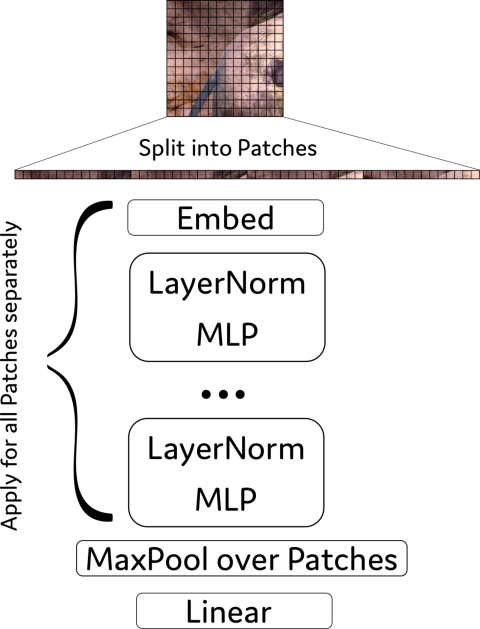

# Towards vision transformers

Key Problems:

- No interaction between patches.
- The patches lost all sense of location.
 

# Localizing patches

Treat each patch location as a categorical variable: Add a (learned) location embedding.

Curiously, we will add this to the patch embedding (rather than, say, concatenate).

Also: Introduce one extra "global location" (just like an additional patch), called the class vector in BERT and ViT. Instead of pooling at the end, we will just the feature for that location. We could use a zero embedding vector here and just use the location embedding, but tradition has it that we use a learned vector for this, too.


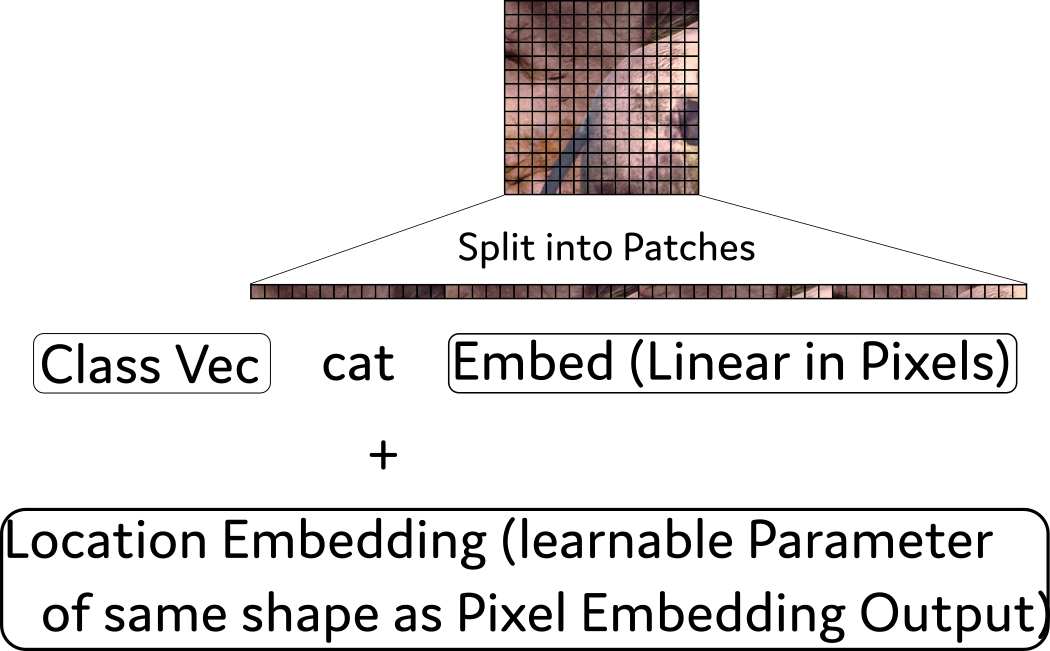

In [38]:
class PatchEmbedding(torch.nn.Module):
    def __init__(self, input_size, patch_size, n_channels):
        super().__init__()
        self.n_channels = n_channels
        num_patches = (input_size ** 2) // (patch_size ** 2)  # only when this is divisible...
        self.patch_to_vec = torch.nn.Conv2d(3, n_channels,
                                    kernel_size=(patch_size, patch_size),
                                    stride=(patch_size, patch_size))  # equivalent to reshape + linear
        self.class_token = torch.nn.Parameter(torch.randn(1, 1, n_channels))  # "global information"
        self.pos_embedding = torch.nn.Parameter(torch.randn(1, num_patches + 1, n_channels))
    
    def forward(self, x):
        bs = x.size(0)
        x = self.patch_to_vec(x)
          # batch x channels x num_patches_y x num_patches_x ---> batch x patches x n_channels
        x = x.view(bs, self.n_channels, -1).permute(0, 2, 1)
        x = torch.cat([self.class_token.expand(bs, -1, -1), x], dim=1)
        x = x + self.pos_embedding
        return x



# Interaction between patches

This is the big transformer novelty, self-attention. (The original transformer paper was titled *Attention is all you need*.)

N.B. Kashif Rasul pointed out that a similar but historically more correct approach is from Seq2Seq-RNNs to *Jointly Learning to Align and Translate* and to Transformers.

# Attention - Looking around us. Where do we look?

Imagine that given an input, you have 9 locations to find something. How would a machine learner predict where to find it?

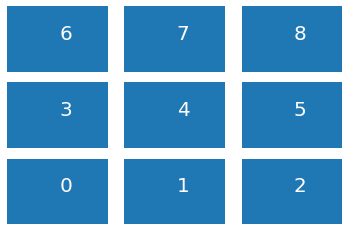

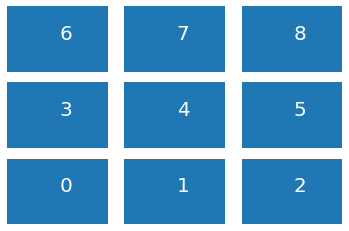

In [54]:
fig, ax = pyplot.subplots(1)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
for i in range(9):
    x, y = i % 3, i // 3
    ax.add_artist(pyplot.Rectangle((x * 0.35, y * 0.35), 0.3, 0.3))
    ax.text(x * 0.35 + 0.175, y * 0.35 + 0.175, f'{i}', c='white', size=20, ha='center', va='center')
ax.axis('off');


... smells like a classification problem!

In [42]:
n_locations = 9
n_channels = 192

x = torch.randn(1, n_channels)  # some input

query_map = torch.nn.Linear(n_channels, n_channels)

# "features" = query
q = query_map(x)
# class vectors = key
k = torch.nn.Parameter(torch.randn(n_locations, n_channels))

logits = torch.einsum('bc,sc->bs', q, k)   # batch x channel, source x channel -> batch x source

logits *= (n_channels**-0.5)  # normalize against staturation
logits.softmax(-1)

tensor([[0.1421, 0.1331, 0.1149, 0.0378, 0.0504, 0.1065, 0.0531, 0.2712, 0.0909]],
       grad_fn=<SoftmaxBackward0>)

But now, we might have an input at every position and decide where to look.

In [43]:
x = torch.randn(1, n_locations, n_channels)  # some input

query_map = torch.nn.Linear(n_channels, n_channels)

# "features" = query
q = query_map(x)
# class vectors = "key"
k = torch.nn.Parameter(torch.randn(n_locations, n_channels))

logits = torch.einsum('btc,sc->bts', q, k)
                      
logits *= (n_channels**-0.5)  # normalize against staturation
logits.softmax(-1)


tensor([[[0.2080, 0.0626, 0.1436, 0.0675, 0.1543, 0.0764, 0.0471, 0.1728,
          0.0678],
         [0.0635, 0.1289, 0.0631, 0.0378, 0.2975, 0.1930, 0.0370, 0.1064,
          0.0728],
         [0.0576, 0.0943, 0.0378, 0.0585, 0.1965, 0.0720, 0.2277, 0.1258,
          0.1298],
         [0.0437, 0.0809, 0.0598, 0.2118, 0.1925, 0.1021, 0.1190, 0.1135,
          0.0766],
         [0.0471, 0.1079, 0.0525, 0.0970, 0.0800, 0.1383, 0.0579, 0.2329,
          0.1865],
         [0.0691, 0.1235, 0.0381, 0.2023, 0.1335, 0.1577, 0.0928, 0.0538,
          0.1293],
         [0.0461, 0.0681, 0.0692, 0.0836, 0.1805, 0.1034, 0.1954, 0.1331,
          0.1206],
         [0.0327, 0.2084, 0.0931, 0.1086, 0.1686, 0.0565, 0.1279, 0.0722,
          0.1321],
         [0.0728, 0.2832, 0.1121, 0.2379, 0.0707, 0.0548, 0.0708, 0.0464,
          0.0512]]], grad_fn=<SoftmaxBackward0>)

Instead of fixed class vectors, we might also derive them from the input!
(We get a new batch dimension in `k`.)

In [44]:
n_locations = 9
x = torch.randn(1, n_locations, n_channels)  # some input

query_map = torch.nn.Linear(n_channels, n_channels)
key_map = torch.nn.Linear(n_channels, n_channels)

q = query_map(x)
k = key_map(x)

logits = torch.einsum('btc,bsc->bts', q, k)
                      
logits *= (n_channels**-0.5)  # normalize against staturation
logits.softmax(-1)


tensor([[[0.0484, 0.1040, 0.1056, 0.1155, 0.1122, 0.1437, 0.1915, 0.0928,
          0.0861],
         [0.1296, 0.0831, 0.0907, 0.0986, 0.1068, 0.0807, 0.1551, 0.1403,
          0.1151],
         [0.1184, 0.1145, 0.0669, 0.0515, 0.1333, 0.1391, 0.1031, 0.1430,
          0.1301],
         [0.0932, 0.0978, 0.1181, 0.1045, 0.1061, 0.0864, 0.2014, 0.1199,
          0.0726],
         [0.0832, 0.1631, 0.0997, 0.1431, 0.1218, 0.0950, 0.0966, 0.1014,
          0.0962],
         [0.0698, 0.0842, 0.1551, 0.0956, 0.1156, 0.1146, 0.1557, 0.1214,
          0.0879],
         [0.1178, 0.0974, 0.1086, 0.0638, 0.1022, 0.0852, 0.1518, 0.1108,
          0.1624],
         [0.1300, 0.1716, 0.0711, 0.1820, 0.1398, 0.0574, 0.0785, 0.0559,
          0.1137],
         [0.1673, 0.0853, 0.0920, 0.0931, 0.0761, 0.0470, 0.1691, 0.0944,
          0.1756]]], grad_fn=<SoftmaxBackward0>)

But what do we see? A linear mapping of the input! Note that we "mix" using the probabilities.

In [45]:
x = torch.randn(1, n_locations, n_channels)  # some input

query_map = torch.nn.Linear(n_channels, n_channels)
key_map = torch.nn.Linear(n_channels, n_channels)
value_map = torch.nn.Linear(n_channels, n_channels)

q = query_map(x)
k = key_map(x)
v = value_map(x)

logits = torch.einsum('btc,bsc->bts', q, k)
                      
logits *= (n_channels**-0.5)  # normalize against staturation
attn = logits.softmax(-1)

output = torch.einsum('bts,bsc->btc', attn, v)  # target source


Multi-Head: Split channels into parts and recombine, also add a linear projection in the end for "head interactions":

In [47]:
n_locations = 9
n_heads = 3
bs = 1
x = torch.randn(bs, n_locations, n_channels)  # some input

query_map = torch.nn.Linear(n_channels, n_channels)
key_map = torch.nn.Linear(n_channels, n_channels)
value_map = torch.nn.Linear(n_channels, n_channels)
projection = torch.nn.Linear(n_channels, n_channels)


q = query_map(x).view(bs, n_locations, n_heads, n_channels // n_heads)
k = key_map(x).view(bs, n_locations, n_heads, n_channels // n_heads)
v = value_map(x).view(bs, n_locations, n_heads, n_channels // n_heads)

logits = torch.einsum('bthc,bshc->bhts', q, k)
                      
logits *= ((n_channels // n_heads) **-0.5)  # normalize against staturation
attn = logits.softmax(-1)

output = torch.einsum('bhts,bshc->bthc', attn, v)  # target source
output = output.reshape(bs, n_locations, n_channels)  # recombine
output = projection(output)

# Variants...

...could also be used for "external" sequence (e.g. for translation).

For "causal" modelling (e.g. predict next timestep), clip the attention to previous "time-steps".

Usually with some dropout added.

Destilled Transformers use a second global token (the destillation token).

## Wrap it into an `nn.Module`

... in the Hands-On.

# Combine

Now that we have everything: Block = "Residual MLP + "Residual" Attention + 2x `LayerNorm` (+ Dropout)


In [48]:
# tag::transformerblock
class Block(torch.nn.Module):
    def __init__(self, n_channels, n_heads, n_hidden):
        super().__init__()
        self.norm1 = torch.nn.LayerNorm(192, eps=1e-6)
        self.attn = TinyAttention(n_channels, n_heads)
        self.norm2 = torch.nn.LayerNorm(192, eps=1e-6)
        self.mlp = MLP(n_channels, n_hidden)
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x
# end::transformerblock

# And here we are:

Vision transformer = Patch Embedding + many (=a dozen for tiny) Blocks + Norm + `Linear` head on the "global" location.

In [49]:
# tag::transformertinydeit
class TinyDEIT(torch.nn.Module):
    def __init__(self, n_classes=1000):
        super().__init__()
        input_size = 224
        patch_size = 16
        n_channels = 192 # 64 * 3
        n_heads = 3
        n_hidden = 768
        n_blocks = 12
        self.patch_embedding = PatchEmbedding(input_size, patch_size, n_channels)
        self.blocks = torch.nn.Sequential(
            *[Block(n_channels, n_heads, n_hidden) for i in range(n_blocks)]
        )
        self.norm = torch.nn.LayerNorm(n_channels, eps=1e-6)
        self.head = torch.nn.Linear(n_channels, n_classes)
    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.blocks(x)
        x = self.norm(x)
        x = self.head(x[:, 0])
        return x
# end::transformertinydeit


# Hands-on!

- Build out the vision transformer.

- Load a deit base (not destilled) transformer from `timm` and adapt the transformer to give the same result.


In [8]:
#import toroidal
import torch
import torchvision
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
t = toroidal.models.DeiTTiny()
t.eval()
for p in t.parameters():
    p.requires_grad_(False)
import torch
x = torch.randn(1, 3, 224, 224)


torch.Size([1, 197, 192])

In [16]:
list(n for n, _ in t.patch_embedding.named_parameters())

['class_token', 'pos_embedding', 'patch_to_vec.weight', 'patch_to_vec.bias']

In [6]:
# tag::patchembed0
class PatchEmbed0(torch.nn.Module):
    def __init__(self, n_features=192):
        super().__init__()
        self.embedding = torch.nn.Linear(3 * 16 * 16, n_features)
    def forward(self, x):
        bs, c, h, w = x.shape
        assert c == 3 and h == 224 and w == 224
        x = x.reshape(bs, 3, 14, 16, 14, 16)  # callout: This splits the tensor along each of the `w` and `h` axes into 14 sections of length 16.
        x = x.permute(0, 2, 4, 1, 3, 5)  # callout: We reorder the dimensions so that we have `batch`, `patches_y`, `patches_x`, `channels`, `in_patch_y`, `in_patch_x` dimensions.
        x = x.reshape(bs, 14 * 14, 3 * 16 * 16)  # callout: Here we combine the dimensions to get a batch, patches, features tensor.
        x = self.embedding(x) # callout: Finally, the linear layer.
        return x
# end::patchembed0

# tag::resmlp
class ResMLP(torch.nn.Sequential):
    def __init__(self, n_features = 192, n_hidden = 768):
        super().__init__()
        self.ln = torch.nn.LayerNorm(n_features, eps=1e-6)
        self.lin1 = torch.nn.Linear(n_features, n_hidden)
        self.act = torch.nn.GELU()
        self.lin2 = torch.nn.Linear(n_hidden, n_features)
    def forward(self, inp):
        x = inp
        x = self.ln(x)
        x = self.lin1(x)
        x = self.act(x)
        x = self.lin2(x)
        x = inp + x
        return x
# end::resmlp

# tag::patchvision
class Max(torch.nn.Module):
    def forward(self, x):
        return x.max(dim=1).values

class PatchVision(torch.nn.Sequential):
    def __init__(self):
        n_categories = 10
        super().__init__(
            PatchEmbed0(),
             *[ResMLP() for x in range(12)],
             torch.nn.LayerNorm(192, eps=1e-6),
             Max(),
             torch.nn.Linear(192, n_categories)      
        )
# end::patchvision

model = PatchVision().to(device)

In [9]:
import tqdm
torchvision.datasets.utils.tqdm = tqdm.cli.tqdm

In [10]:
# imagenette downloading with torchvision
import torchvision.datasets.utils
if not torchvision.datasets.utils.check_integrity(
    'data/imagenette2-320.tgz',
    md5='3df6f0d01a2c9592104656642f5e78a3'):
    torchvision.datasets.utils.download_and_extract_archive(
        'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz',
        './data',
        md5='3df6f0d01a2c9592104656642f5e78a3')

In [12]:
ds_train = torchvision.datasets.ImageFolder(
    './data/imagenette2-320/train/',
    transform=torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop((224, 224)),  # callout: using `RandomResizedCrop` is typical for training.
        torchvision.transforms.ToTensor(),
    ]))


ds_val = torchvision.datasets.ImageFolder(
    './data/imagenette2-320/val/',
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),  # callout: Using `Resize` and `CenterCrop` is typical for validation and production.
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
    ]))

In [13]:
dl_train = torch.utils.data.DataLoader(
    ds_train, batch_size=128, shuffle=True, drop_last=True, num_workers=8)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=128, num_workers=8)

In [16]:
img_transform = torchvision.transforms.Normalize(
    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
opt = torch.optim.Adam(model.parameters(), lr=3e-4)

for epoch in range(10):
    model.train()
    total_loss = torch.zeros((), device=device)  # callout: By computing the average loss on the GPU, we avoid a synchronization point (the CPU waiting on the GPU) in our training loop.
    for i, (img, lab) in enumerate(dl_train):
        img = img.to(device)
        lab = lab.to(device)
        
        img = img_transform(img)  # callout: Here we compute the normalization.
        
        pred = model(img)
        loss = torch.nn.functional.cross_entropy(pred, lab)
        total_loss = total_loss + loss.detach() / len(dl_train)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
    print(epoch, total_loss.item())  # callout: Here, we synchronize and get the total loss for the epoch.

0 1.442641019821167
1 1.3834483623504639
2 1.3122873306274414
3 1.2652969360351562
4 1.248573660850525
5 1.1997448205947876
6 1.189523458480835
7 1.1621562242507935
8 1.1596901416778564
9 1.124880075454712


In [98]:
def validate_accuracy(model, val_dl, transform=None, lab_transform=None):
    model.to(device).eval()
    num_acc = 0
    num_total = 0
    for img, lab in val_dl:
        img = img.to(device)
        if transform is not None:
            img = transform(img)
        if lab_transform is not None:
            lab = lab_transform(lab)
        lab = lab.to(device)
        with torch.no_grad():
            pred = model(img).argmax(1)
        num_acc = num_acc + (pred == lab).sum()
        num_total += len(lab)
    num_acc = num_acc.item()
    return (num_acc / num_total)

validate_accuracy(model, dl_val, transform=img_transform)


0.7253503184713376

In [99]:
model

PatchVision(
  (0): PatchEmbed0(
    (embedding): Linear(in_features=768, out_features=192, bias=True)
  )
  (1): ResMLP(
    (ln): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
    (lin1): Linear(in_features=192, out_features=768, bias=True)
    (act): GELU(approximate=none)
    (lin2): Linear(in_features=768, out_features=192, bias=True)
  )
  (2): ResMLP(
    (ln): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
    (lin1): Linear(in_features=192, out_features=768, bias=True)
    (act): GELU(approximate=none)
    (lin2): Linear(in_features=768, out_features=192, bias=True)
  )
  (3): ResMLP(
    (ln): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
    (lin1): Linear(in_features=192, out_features=768, bias=True)
    (act): GELU(approximate=none)
    (lin2): Linear(in_features=768, out_features=192, bias=True)
  )
  (4): ResMLP(
    (ln): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
    (lin1): Linear(in_features=192, out_features=768, bias=True)
    (act

In [7]:
a = torch.jit.script(model[1])
v = JITVisualizer(a)
v.show_interactive_graph()

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


<IPython.core.display.Javascript object>

In [10]:
with open("../../images/ch09_new/ch09_new_fig2_resmlpdiag.svg", "w") as f:
    f.write(v.make_svg())
IPython.display.HTML(v.make_svg())

In [13]:
a = torch.jit.script(model)
v = JITVisualizer(a)

with open("../../images/ch09_new/ch09_new_fig3_patchvision.svg", "w") as f:
    f.write(v.make_svg())

IPython.display.HTML(v.make_svg())


In [30]:
# tag::patchembed
class PatchEmbed(torch.nn.Module):
    def __init__(self, n_features=192):
        super().__init__()
        self.embedding = torch.nn.Linear(3 * 16 * 16, n_features)
        self.class_token = torch.nn.Parameter(  # callout: The learnable input value for the patch containing global information.
            torch.randn(1, 1, n_features)
        )
        self.pos_embedding = torch.nn.Parameter(  # callout: The positional embedding, our _learned coordinates_.
            torch.randn(1, 14 * 14 + 1, n_features)
        )
    def forward(self, x):
        bs, c, h, w = x.shape
        assert c == 3 and h == 224 and w == 224
        x = x.reshape(bs, 3, 14, 16, 14, 16)  # callout: These, until embedding, are as before.
        x = x.permute(0, 2, 4, 1, 3, 5) 
        x = x.reshape(bs, 14 * 14, 3 * 16 * 16)
        x = self.embedding(x)
        x = torch.cat([self.class_token.expand(bs, -1, -1), x], dim=1)  # callout: We concatenate the the class token as the 197th patch (but in front).
        x = x + self.pos_embedding  # callout: Here, we add the positional embedding, the learned coordinates.
        return x
# end::patchembed


In [16]:
m.state_dict().keys()

odict_keys(['class_token', 'pos_embedding', 'embedding.weight', 'embedding.bias'])

In [26]:
m2 = toroidal.models.VisionPatchEmbedding(224, 16, 192)
m.load_state_dict({k.replace('patch_to_vec', 'embedding'):v.view(192, -1) if k == 'patch_to_vec.weight' else v for k,v in m2.state_dict().items()})

<All keys matched successfully>

In [29]:
(m2(i)-m(i)).abs().max()

tensor(2.3842e-06, grad_fn=<MaxBackward1>)

In [37]:
# tag::attention0
class Attention0(torch.nn.Module):
    def __init__(self, n_patches = 197, n_features = 192):
        super().__init__()
        self.query_map = torch.nn.Linear(n_features, n_features) 
        self.key_map = torch.nn.Linear(n_features, n_features)
        self.n_patches = n_patches
        self.n_features = n_features
    def forward(self, x):
        q = self.query_map(x)
        k = self.key_map(x)
        logits = torch.einsum('btf,bsf->bts', q, k)  # callout: Here we take all pairwise dot products between the patches.
        logits *= (self.n_features**-0.5)  # callout: This normalization scales down the unnormalized probabilities and causes the softmax output to be more spread out between the classes. The goal is to guard against staturation of the softmax and achieve better training performance.
        attn_weights = logits.softmax(-1)
        out = torch.einsum('bts,bsf->btf', attn_weights, x)  # callout: Here we apply the weights to the inputs.
        return out
# end::attention0

m = Attention0()
x = torch.randn(1, m.n_patches, m.n_features)  # callout: a test input, batch size 1
m(x)

tensor([[[-0.2095,  0.0605,  0.1514,  ..., -0.0075,  0.0546, -0.0929],
         [-0.1754,  0.0617,  0.1314,  ...,  0.0060,  0.0518, -0.0097],
         [-0.2141,  0.0230,  0.1254,  ..., -0.0453,  0.0479, -0.0341],
         ...,
         [-0.1950, -0.0187,  0.1453,  ..., -0.0289, -0.0176, -0.0566],
         [-0.1511,  0.0239,  0.1172,  ..., -0.0835,  0.0182, -0.0894],
         [-0.2041,  0.0408,  0.1515,  ..., -0.0541,  0.1125, -0.0246]]],
       grad_fn=<ViewBackward0>)

In [53]:
# tag::attention1
class Attention1(torch.nn.Module):
    def __init__(self, n_patches = 197, n_features = 192):
        super().__init__()
        self.query_map = torch.nn.Linear(n_features, n_features) 
        self.key_map = torch.nn.Linear(n_features, n_features)
        self.value_map = torch.nn.Linear(n_features, n_features)
        self.projection = torch.nn.Linear(n_features, n_features)
        self.n_patches = n_patches
        self.n_features = n_features
    def forward(self, x):
        q = self.query_map(x)
        k = self.key_map(x)
        v = self.value_map(x)
        logits = torch.einsum('btf,bsf->bts', q, k)  # callout: Here we take all pairwise dot products between the patches.
        logits *= (self.n_features**-0.5)  # callout: This normalization scales down the unnormalized probabilities and causes the softmax output to be more spread out between the classes. The goal is to guard against staturation of the softmax and achieve better training performance.
        attn_weights = logits.softmax(-1)
        out = torch.einsum('bts,bsf->btf', attn_weights, v)  # callout: Here we apply the weights to the inputs.
        out = self.projection(out)
        return out
# end::attention1

m = Attention1()
x = torch.randn(1, m.n_patches, m.n_features)  # callout: a test input, batch size 1
m(x)

tensor([[[-0.0699,  0.1157,  0.0471,  ..., -0.0051,  0.0177, -0.0038],
         [-0.0934,  0.0989,  0.0453,  ..., -0.0087,  0.0102, -0.0099],
         [-0.0871,  0.1158,  0.0515,  ..., -0.0176,  0.0260, -0.0166],
         ...,
         [-0.0852,  0.1097,  0.0593,  ..., -0.0097,  0.0223, -0.0187],
         [-0.0861,  0.1084,  0.0422,  ..., -0.0310,  0.0443, -0.0222],
         [-0.1026,  0.0995,  0.0385,  ..., -0.0209,  0.0367, -0.0193]]],
       grad_fn=<AddBackward0>)

In [54]:
# tag::attention_multihead
class AttentionMultiHead(torch.nn.Module):
    def __init__(self, n_patches = 197, n_features = 192, n_heads=3):
        super().__init__()
        self.n_heads = n_heads
        self.query_map = torch.nn.Linear(n_features, n_features)
        self.key_map = torch.nn.Linear(n_features, n_features)
        self.value_map = torch.nn.Linear(n_features, n_features)
        self.projection = torch.nn.Linear(n_features, n_features)
        self.n_patches = n_patches
        self.n_features = n_features
    def forward(self, x):
        bs, n_patches = x.shape[:2]
        q = self.query_map(x).view(bs, n_patches, self.n_heads, -1)
        k = self.key_map(x).view(bs, n_patches, self.n_heads, -1)
        v = self.value_map(x).view(bs, n_patches, self.n_heads, -1)
        logits = torch.einsum('bthf,bshf->bths', q, k)  # callout: Now we add a batch dimension for the heads.
        logits *= ((self.n_features/self.n_heads)**-0.5)  # callout: As we take the softmax over the heads separately, we also adjust the scaling.
        attn_weights = logits.softmax(-1)
        out = torch.einsum('bths,bshf->bthf', attn_weights, v)  # callout: Here, too, a head dimension is added.
        out = out.reshape(bs, n_patches, -1)  # callout: finally, we combine the heads' output into one large feature vector again.
        out = self.projection(out)
        return out
# end::attention_multihead

m = AttentionMultiHead()
x = torch.randn(1, m.n_patches, m.n_features)  # callout: a test input, batch size 1
m(x)

tensor([[[ 0.0517, -0.0661,  0.0380,  ...,  0.0072, -0.0202, -0.0245],
         [ 0.0459, -0.0790,  0.0422,  ...,  0.0217, -0.0129, -0.0088],
         [ 0.0262, -0.0756,  0.0493,  ...,  0.0089, -0.0480, -0.0170],
         ...,
         [ 0.0365, -0.0728,  0.0455,  ...,  0.0212, -0.0244,  0.0017],
         [ 0.0437, -0.0741,  0.0538,  ...,  0.0068, -0.0095, -0.0034],
         [ 0.0562, -0.0608,  0.0491,  ...,  0.0103, -0.0346, -0.0086]]],
       grad_fn=<AddBackward0>)

In [39]:
import toroidal

In [40]:
?? toroidal.models.Attention

In [ ]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(
        self,
        n_channels,
        n_heads,
        block_size=128,
    ):
        super().__init__()
        self.n_channels = n_channels
        self.n_heads = n_heads
        self.scale = (n_channels // n_heads) ** -0.5
        self.qkv = torch.nn.Linear(n_channels, 3 * n_channels)
        self.proj = torch.nn.Linear(n_channels, n_channels)
        torch.nn.init.normal_(self.qkv.weight, std=0.02)
        torch.nn.init.zeros_(self.qkv.bias)
        torch.nn.init.normal_(self.proj.weight, std=0.02)
        torch.nn.init.zeros_(self.proj.bias)

    def forward(self, x):
        bs, n_locations, n_channels = x.shape
        n_heads = self.n_heads

        # this is a trick to do q, k, v in one large linear for efficiency
        # unbind splits a tensor into a tuple of tensors
        q, k, v = self.qkv(x).view(bs, n_locations, 3, n_heads, -1).unbind(dim=2)

        logits = torch.einsum("bthc,bshc->bhts", q, k)
        logits *= self.scale  # normalize against staturation
        attn = logits.softmax(-1)
        output = torch.einsum("bhts,bshc->bthc", attn, v)  # target source
        output = output.reshape(bs, n_locations, n_channels)  # recombine
        output = self.proj(output)
        return output

In [47]:
m= toroidal.models.DeiTTiny()
m.blocks[0].attn.n_heads

3